# FEM 1D multiscale example

This script finds an approximate solution to the equation

$$\ddot{u}_\varepsilon - \nabla \cdot (A_\varepsilon \nabla \dot{u}_\varepsilon + B_\varepsilon \nabla u_\varepsilon) = 1, \ \text{in } \Omega,$$

with homogeneous Dirichlet boundary condition. The multiscale coefficients are given by

$$A_\varepsilon(x) = (2 - \sin(2\pi x/\varepsilon_A)), \qquad B_\varepsilon(x) = (2 - \cos(2\pi x/\varepsilon_B)),$$

with $\varepsilon_A = \varepsilon_B = 2^{-5}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gridlod import util, fem
from gridlod.world import World
import femsolverWave

'''
Settings
'''

# fine settings
fine = 4096                                                                         #Fine mesh size
NFine = np.array([fine])
NpFine = np.prod(NFine+1)                                                           #Number of fine mesh nodes
NList = [2, 4, 8, 16, 32, 64, 128, 256]                                             #Coarse mesh sizes
boundaryConditions = np.array([[0, 0]])

# create world
world = World(np.array([fine/2]), NFine/np.array([fine/2]), boundaryConditions)

# fine grid nodes
pi = np.pi
xt = util.tCoordinates(NFine).flatten()                                             #Coordinates for center of elements
xp = util.pCoordinates(NFine).flatten()                                             #Coordinates for nodes

# time step parameters
tau = 0.01                                                                           #Time step
numTimeSteps = 1000                                                                 #Number of time steps

# ms coefficients
eps = 2**(-5)
aFine = (2 - np.sin(2*pi*xt/eps))**(-1)                                             #Coefficient A(x)
bFine = (2 - np.cos(2*pi*xt/eps))**(-1) 

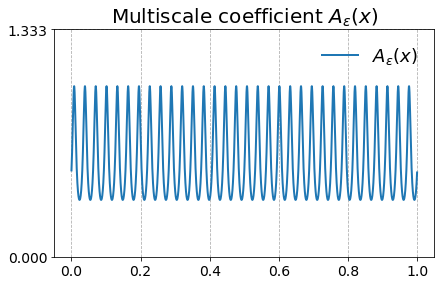

In [3]:
# plot A(x)
plt.figure('Coefficient')
plt.subplots_adjust(left=0.11, bottom=0.13, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xt,aFine, linewidth=2, label='$A_{\epsilon}(x)$')
plt.yticks((0,np.max(aFine)+np.min(aFine)),fontsize=14)
plt.legend(frameon=False,fontsize=18)
plt.title('Multiscale coefficient $A_{\epsilon}(x)$', fontsize=20)
plt.grid(True,which="both",ls="--")
plt.show()


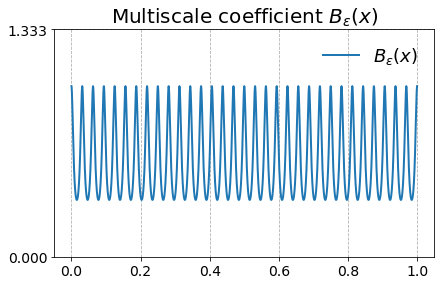

In [4]:
# plot B(x)
plt.figure('Coefficient')
plt.subplots_adjust(left=0.11, bottom=0.13, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xt,bFine, linewidth=2, label='$B_{\epsilon}(x)$')
plt.yticks((0,np.max(aFine)+np.min(aFine)),fontsize=14)
plt.legend(frameon=False,fontsize=18)
plt.title('Multiscale coefficient $B_{\epsilon}(x)$', fontsize=20)
plt.grid(True,which="both",ls="--")
plt.show()


In [5]:


'''
Compute reference solution
'''

# initial values
Uo = np.zeros(NpFine)
Vo = np.ones(NpFine)*0.1
uSol = [Uo]
V = [Vo]

# compute reference solution
for i in xrange(numTimeSteps):
    f = np.ones(NpFine)
    uSol.append(femsolverWave.solveFine_fem(world, aFine, bFine, f, uSol, tau, boundaryConditions, i))

# declare lists for plot usage
solutions = []
xpCoarseList = []
error = []
x = []
y = []

'''
Compute approximate solution
'''

for N in NList:

    # create world
    NWorldCoarse = np.array([N])
    boundaryConditions = np.array([[0, 0]])                                             #Dirichlet B.C.
    NCoarseElement = NFine/NWorldCoarse
    world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

    # coarse grid nodes
    xpCoarse = util.pCoordinates(NWorldCoarse).flatten()                                #Coarse nodes
    xpCoarseList.append(xpCoarse)                                                       #Store for plot
    NpCoarse = np.prod(NWorldCoarse+1)                                                  #Number of coarse nodes

    # create lists for storage
    f = np.ones(NpFine)                                                                             #Storage of source term at each time step t
    Uo = np.zeros(NpCoarse)                                                             #Discrete initial value
    Vo = 0.1*np.ones(NpCoarse)
    U = [Uo]                                                                            #Store initial value as first solution
    V = [Vo]                                                                            #Store initial derivative as first derivative

    # solve for each time step
    for i in xrange(numTimeSteps):
        #t = tau * (i+1)
        uCoarseFull = femsolverWave.solveCoarse_fem(world, aFine, bFine, f, U, tau, boundaryConditions, i)
        U.append(uCoarseFull)
        V.append((U[i+1] - U[i]) / tau)

    # append solution for this mesh size
    solutions.append(U)

    # Append L2-error (at final time step)
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    uLodCoarse = basis * uCoarseFull
    error.append(np.sqrt(np.dot((uSol[-1] - uLodCoarse), (uSol[-1] - uLodCoarse))))
    x.append(N)
    y.append(1. / N)


Plot the solutions next to the reference solution.

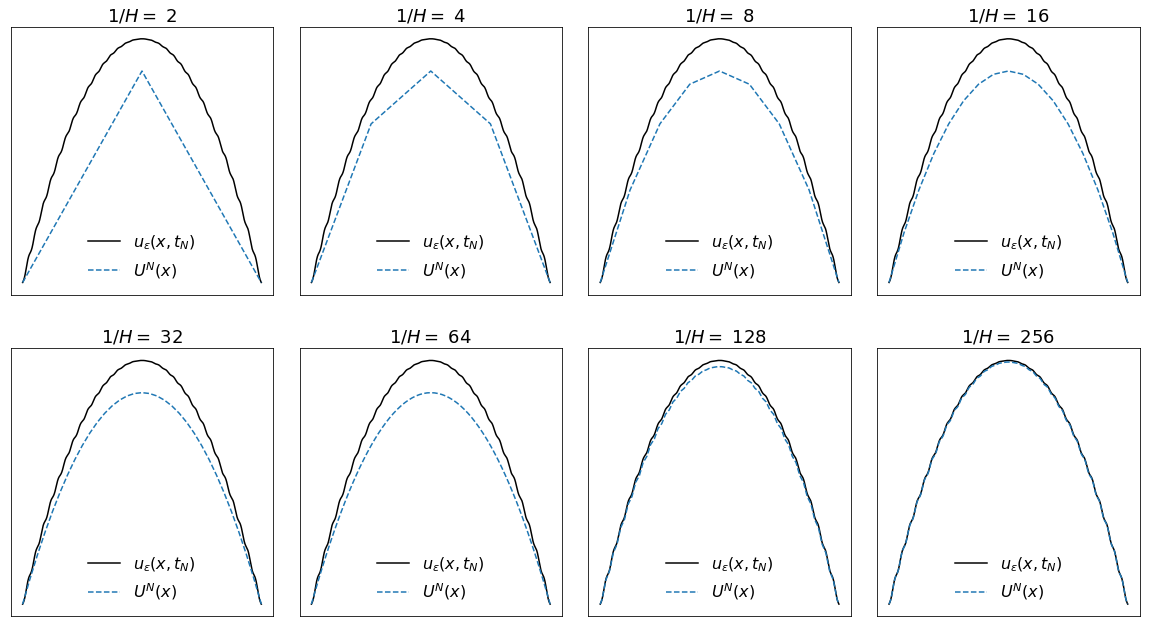

In [6]:
#Plot solutions
plt.figure('FEM-Solutions', figsize=(16, 9))
plt.subplots_adjust(left=0.01, bottom=0.04, right=0.99, top=0.95, wspace=0.1, hspace=0.2)
for i in xrange(len(NList)):
    plt.subplot(2,4,i+1)
    plt.plot(xp, uSol[-1], 'k', label='$u_\epsilon(x,t_N)$')
    plt.plot(xpCoarseList[i], solutions[i][-1], '--', label='$U^N(x)$')
    plt.title('$1/H=$ ' + str(2**(i+1)), fontsize=18)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off',
                    labelleft='off')
    plt.legend(frameon=False, fontsize=16)
plt.show()

Plot the $L^2$-error.

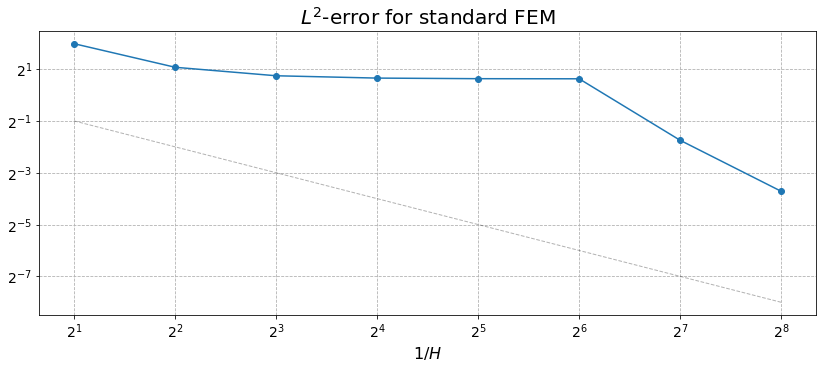

In [7]:
#Plot errors
plt.figure("Error", figsize=(12,5))
plt.subplots_adjust(left=0.09, bottom=0.13, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.loglog(x,error,'o-', basex=2, basey=2)
plt.loglog(x,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.3)
plt.xlabel('$1/H$', fontsize=16)
plt.title('$L^2$-error for standard FEM', fontsize=20)
plt.grid(True,which="both",ls="--")
plt.show()